### 1. Loaded Embeddings and Labels

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from torch.utils.data import DataLoader, TensorDataset

START_TAG = "<START>"
STOP_TAG = "<STOP>"

In [2]:
import pickle
import json
import numpy as np

# Function to load the data from the json file
def load_from_json(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

# Load these embeddings from the pickle files
train_embeddings_file = "/home/medha/NLP/Assignment2-Local/Task1_Word2Vec_train_embeddings.pkl"
val_embeddings_file = "/home/medha/NLP/Assignment2-Local/Task1_Word2Vec_val_embeddings.pkl"
test_embeddings_file = "/home/medha/NLP/Assignment2-Local/Task1_Word2Vec_test_embeddings.pkl"

train_embeddings_loaded = pickle.load(open(train_embeddings_file, "rb"))
val_embeddings_loaded = pickle.load(open(val_embeddings_file, "rb"))
test_embeddings_loaded = pickle.load(open(test_embeddings_file, "rb"))

# Load the labels from the json files
train_labels = {}
val_labels = {}
test_labels = {}

train_label_path = "/home/medha/NLP/CSE556-NLP-Assignments/Assignment 2/Task1_Dataset_NER/NER_train_labels.json"
val_label_path = "/home/medha/NLP/CSE556-NLP-Assignments/Assignment 2/Task1_Dataset_NER/NER_val_labels.json"
test_label_path = "/home/medha/NLP/CSE556-NLP-Assignments/Assignment 2/Task1_Dataset_NER/NER_test_labels.json"

train_labels = load_from_json(train_label_path)
val_labels = load_from_json(val_label_path)
test_labels = load_from_json(test_label_path)

2. Remove samples above length of 174

In [3]:
# discarding the sentences with length greater than 174
# for train

train_labels = {k: v for k, v in train_labels.items() if len(v) <= 174}
train_embeddings_loaded = {k: v for k, v in train_embeddings_loaded.items() if len(v) <= 174}

# for val
val_labels = {k: v for k, v in val_labels.items() if len(v) <= 174}
val_embeddings_loaded = {k: v for k, v in val_embeddings_loaded.items() if len(v) <= 174}

# for test
test_labels = {k: v for k, v in test_labels.items() if len(v) <= 174}
test_embeddings_loaded = {k: v for k, v in test_embeddings_loaded.items() if len(v) <= 174}

3. Padding of the sentences to get same sequence lengths

In [4]:
"""
For each key, pad the embeddings and labels to the maximum length of 174 (for Task 1) and 83 (for Task 2)
For padding labels, use 'O' tag
For padding embeddings, use a vector of zeros
"""

max_length = 174

# Train Embeddings and Labels   
for key in train_embeddings_loaded:
    label = train_labels[key]
    embeddings = train_embeddings_loaded[key]

    # Pad the labels
    if len(label) < max_length:
        label = label + ['O'] * (max_length - len(label))

    # Pad the embeddings
    if len(embeddings) < max_length:
        embeddings = np.concatenate((embeddings, np.zeros((max_length - len(embeddings), 300))), axis=0)

    train_labels[key] = label
    train_embeddings_loaded[key] = embeddings

# Val Embeddings and Labels
for key in val_embeddings_loaded:
    label = val_labels[key]
    embeddings = val_embeddings_loaded[key]

    # Pad the labels
    if len(label) < max_length:
        label = label + ['O'] * (max_length - len(label))

    # Pad the embeddings
    if len(embeddings) < max_length:
        embeddings = np.concatenate((embeddings, np.zeros((max_length - len(embeddings), 300))), axis=0)

    val_labels[key] = label
    val_embeddings_loaded[key] = embeddings

# Test Embeddings and Labels
for key in test_embeddings_loaded:
    label = test_labels[key]
    embeddings = test_embeddings_loaded[key]

    # Pad the labels
    if len(label) < max_length:
        label = label + ['O'] * (max_length - len(label))

    # Pad the embeddings
    if len(embeddings) < max_length:
        embeddings = np.concatenate((embeddings, np.zeros((max_length - len(embeddings), 300))), axis=0)

    test_labels[key] = label
    test_embeddings_loaded[key] = embeddings

4. Label Indexing

In [5]:
# Get the unique labels
unique_labels = set()
for labels in train_labels.values():
    unique_labels.update(labels)

# Add the start and stop tags
unique_labels.add(START_TAG)
unique_labels.add(STOP_TAG)

# Give each label a unique index
labels_to_index = {label: index for index, label in enumerate(unique_labels)}
print(labels_to_index)

{'B_ORG': 0, 'B_JUDGE': 1, 'I_PETITIONER': 2, 'I_PROVISION': 3, 'B_DATE': 4, 'I_ORG': 5, 'B_RESPONDENT': 6, 'B_STATUTE': 7, 'B_CASE_NUMBER': 8, 'O': 9, '<STOP>': 10, 'I_RESPONDENT': 11, 'B_PRECEDENT': 12, 'I_CASE_NUMBER': 13, 'I_GPE': 14, 'B_WITNESS': 15, 'B_GPE': 16, 'B_PETITIONER': 17, 'I_DATE': 18, '<START>': 19, 'I_JUDGE': 20, 'I_COURT': 21, 'B_PROVISION': 22, 'I_PRECEDENT': 23, 'B_OTHER_PERSON': 24, 'I_STATUTE': 25, 'I_WITNESS': 26, 'I_OTHER_PERSON': 27, 'B_COURT': 28}


In [6]:
# Function to convert labels to indices
def labels_to_indices(labels, label_to_index):
    return [[label_to_index[label] for label in sentence_labels] for sentence_labels in labels]

# Convert the labels to indices
train_labels_indices = labels_to_indices(train_labels.values(), labels_to_index)
val_labels_indices = labels_to_indices(val_labels.values(), labels_to_index)
test_labels_indices = labels_to_indices(test_labels.values(), labels_to_index)

In [7]:
train_embeddings_tensor = torch.tensor([train_embeddings_loaded[key] for key in train_labels], dtype=torch.float)
train_labels_tensor = torch.tensor(train_labels_indices, dtype=torch.long)

val_embeddings_tensor = torch.tensor([val_embeddings_loaded[key] for key in val_labels], dtype=torch.float)
val_labels_tensor = torch.tensor(val_labels_indices, dtype=torch.long)

test_embeddings_tensor = torch.tensor([test_embeddings_loaded[key] for key in test_labels], dtype=torch.float)
test_labels_tensor = torch.tensor(test_labels_indices, dtype=torch.long)
                                  
# Create the DataLoader
train_dataset = TensorDataset(train_embeddings_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_embeddings_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_embeddings_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

/tmp/ipykernel_716866/3698785045.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  train_embeddings_tensor = torch.tensor([train_embeddings_loaded[key] for key in train_labels], dtype=torch.float)


### BiLSTM-CRF Code

In [8]:
"""
Helper functions to train the model
"""

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BiLSTM_CRF(nn.Module):

    def __init__(self, tag_to_ix, embedding_dim, hidden_dim, batch_size):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.tag_to_ix = tag_to_ix
        self.batch_size = batch_size
        self.tagset_size = len(tag_to_ix)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

    def init_hidden(self, batch_size):
        num_layers = 2 if self.lstm.bidirectional else 1
        hidden = (torch.randn(num_layers, batch_size, self.hidden_dim // 2),
            torch.randn(num_layers, batch_size, self.hidden_dim // 2))
        
        # Move the hidden state to GPU if available
        hidden = (hidden[0].to(device), hidden[1].to(device))
        return hidden

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Move all tensors to GPU if available
        forward_var = forward_var.to(device)

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, embeds):
        hidden = self.init_hidden(batch_size=embeds.shape[0])
        embeds = embeds.permute(1, 0, 2)

        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.permute(1, 0, 2).contiguous().view(-1, self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = tags.view(-1) # flatten the tags

        # Move tensors to GPU if available
        tags = tags.to(device)
        score = score.to(device)
        feats = feats.to(device)

        #print(torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).shape)
        start_tag_tensor = torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device)
        tags = torch.cat([start_tag_tensor, tags], dim=0)
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, embeddings, tags):
        feats = self._get_lstm_features(embeds=embeddings)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [17]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

EMBEDDING_DIM = 300
HIDDEN_DIM = 256
BATCH_SIZE = 1
NUM_CLASSES = len(labels_to_index)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model
model = BiLSTM_CRF(labels_to_index, EMBEDDING_DIM, HIDDEN_DIM, BATCH_SIZE)

# Move the model to the device
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

EPOCHS = 10

train_losses = []
val_losses = []
train_f1 = []
val_f1 = []

# Training loop
for epoch in range(EPOCHS):
    running_train_loss = 0.0
    running_val_loss = 0.0
    train_preds = []
    val_preds = []
    train_true = []
    val_true = []
    for i, (embeddings, labels) in enumerate(train_loader):
        print(i)
        # Clear gradients
        model.zero_grad()

        # Move the data to the device
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        #print(f"Embeddings: {embeddings.shape}, Labels: {labels.shape}")
        # Run forward pass
        loss = model.neg_log_likelihood(embeddings, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Prediction
        _, predicted = model(embeddings)
        predicted = torch.tensor(predicted, dtype=torch.long)
        labels = labels.view(-1)
        predicted = predicted.view(-1)

        # Calculate running training loss
        running_train_loss += loss.item()

        # Append the predictions and true labels
        train_preds.extend(predicted.tolist())
        train_true.extend(labels.tolist())

    # Calculate the training loss
    running_train_loss /= len(train_loader)
    train_losses.append(running_train_loss)

    # Calculate the training f1 score
    train_f1.append(f1_score(train_true, train_preds, average='macro'))

    # Calculate the training accuracy
    train_accuracy = accuracy_score(train_true, train_preds)

    # Validation loop
    with torch.no_grad():
        for i, (embeddings, labels) in enumerate(val_loader):
            # Move the data to the device
            embeddings = embeddings.to(device)
            labels = labels.to(device)

            # Run forward pass
            loss = model.neg_log_likelihood(embeddings, labels)

            # Prediction
            _, predicted = model(embeddings)
            predicted = torch.tensor(predicted, dtype=torch.long)
            labels = labels.view(-1)
            predicted = predicted.view(-1)

            # Calculate running validation loss
            running_val_loss += loss.item()

            # Append the predictions and true labels
            val_preds.extend(predicted.tolist())
            val_true.extend(labels.tolist())

    # Calculate the validation loss
    running_val_loss /= len(val_loader)
    val_losses.append(running_val_loss)

    # Calculate the validation f1 score
    val_f1.append(f1_score(val_true, val_preds, average='macro'))

    # Calculate the validation accuracy
    val_accuracy = accuracy_score(val_true, val_preds)

    print(f'Epoch [{epoch + 1}/{EPOCHS}], Train Loss: {running_train_loss:.4f}, Train F1: {train_f1[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {running_val_loss:.4f}, Val F1: {val_f1[-1]:.4f}, Val Accuracy: {val_accuracy:.4f}')        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76


KeyboardInterrupt: 

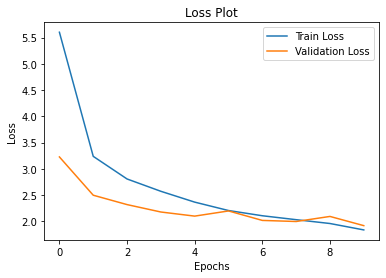

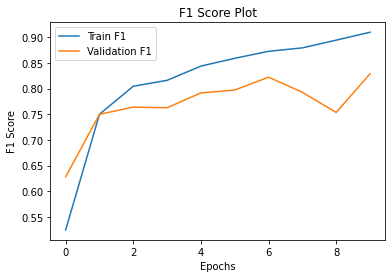

In [ ]:
# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Plot")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation f1 score
plt.plot(train_f1, label='Train F1')
plt.plot(val_f1, label='Validation F1')
plt.title("F1 Score Plot")
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
# Test loop
test_preds = []
test_true = []

with torch.no_grad():
    for i, (embeddings, labels) in enumerate(test_loader):
        # Run forward pass
        _, predicted = model(embeddings)
        predicted = torch.tensor(predicted, dtype=torch.long)
        labels = labels.view(-1)
        predicted = predicted.view(-1)

        # Append the predictions and true labels
        test_preds.extend(predicted.tolist())
        test_true.extend(labels.tolist())

# Calculate the test f1 score
test_f1 = f1_score(test_true, test_preds, average='macro')

# Calculate the test accuracy
test_accuracy = accuracy_score(test_true, test_preds)

print(f'Test F1: {test_f1:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test F1: 0.7984, Test Accuracy: 0.9871


In [ ]:
# Save the model to a pt file
torch.save(model.state_dict(), 'Task2_BiLSTMCRF_Word2Vec.pt')